In [1]:
import pandas as pd
from nlpia.data.loaders import get_data

pd.options.display.width = 120

sms = get_data('sms-spam')
sms['spam'] = sms.spam.astype(int)
sms.columns = ['spam','sms' ]

d:\program files\python37\lib\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
d:\program files\python37\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
d:\program files\python37\lib\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
d:\program files\python37\lib\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
INFO:nlpia.constants:Sta

In [2]:
df1 = sms.loc[sms.loc[:, 'spam'] == 1]
df2 = sms.loc[sms.loc[:, 'spam'] == 0]

In [ ]:
print(len(df1))
print(len(df2))
df1

In [3]:
df1 = pd.concat([df1,df1,df1,df1,df1,df1])
print(len(df1))

3828


In [4]:
df = pd.concat([df1,df2])
df.columns = ['spam','sms']
print(len(df))

8027


Aplicamos un preprocesador un poco mas avanzado, que retira numeros

In [75]:
import re
def preprocesador1(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'\d','', text)
    #emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    #emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|\(|D|P)', text)
    emoticons = re.findall('(?::|;|=|X)(?:-)?(?:\)|\(|D|P)', text)
    print(emoticons)
    text = (re.sub('[\W]+', ' ', text.lower())+ ' ' + ' '.join(emoticons).replace('-', '').replace('=', ':'))
    return text

In [77]:
preprocesador1("hello XD hi")

['XD']


'hello xd hi XD'

In [40]:
df['sms'] = df['sms'].apply(preprocesador1)

NameError: name 'df' is not defined

Barajamos la base de datos, ya que la concatenacion nos deja la base de datos muy ordenada

In [7]:
from sklearn.utils import shuffle

df = shuffle(df)
df = shuffle(df)
print(len(df))
df.head(8)

8027


,spam,sms
308,1,okmail dear dave this is your final notice to ...
2707,1,hi babe its jordan how r u im home from abroad...
1904,1,splashmobile choose from s of gr tones each wk...
562,1,all the lastest from stereophonics marley dizz...
2945,1,rct thnq adrian for u text rgds vatian
1026,0,hope you are feeling great pls fill me in abiola
4550,1,urgent you have won a week free membership in ...
225,1,new mobiles from must go txt nokia to no coll...


In [8]:
from nlpia.loaders import get_data

wv = get_data('word2vec')

INFO:nlpia.loaders:Downloading word2vec
DEBUG:nlpia.futil:regex pattern = ^[.]?([^.]*)\.([^.]{1,10})*\.300d\.zip$, string=googlenews-vectors-negative300.bin.gz
DEBUG:nlpia.futil:regex pattern = ^[.]?([^.]*)\.([^.]{1,10})*\.27b\.zip$, string=googlenews-vectors-negative300.bin.gz
DEBUG:nlpia.futil:regex pattern = ^[.]?([^.]*)\.([^.]{1,10})*\.42b\.zip$, string=googlenews-vectors-negative300.bin.gz
DEBUG:nlpia.futil:regex pattern = ^[.]?([^.]*)\.([^.]{1,10})*\.6b\.zip$, string=googlenews-vectors-negative300.bin.gz
DEBUG:nlpia.futil:regex pattern = ^[.]?([^.]*)\.([^.]{1,10})*\.bin\.gz$, string=googlenews-vectors-negative300.bin.gz
DEBUG:nlpia.futil:regex pattern = ^[.]?([^.]*)\.([^.]{1,10})*\.tgz$, string=googlenews-vectors-negative300.bin.gz
INFO:nlpia.loaders:expanded+normalized file path: d:\program files\python37\lib\site-packages\nlpia\bigdata\googlenews-vectors-negative300.bin.gz
INFO:nlpia.loaders:requesting URL: https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative30

# Tokenizacion y Vectorizacion
Tokenizamos y vectorizamos con word2vec

In [9]:
import nltk

def tokenizar_y_vectorizar(dataset):
    corpus = dataset['sms'].values.tolist()
    tok_corp = [nltk.word_tokenize(sent) for sent in corpus]
    vectorized_data = []
    for sample in tok_corp:
        vectors = [wv[w] for w in sample if w in wv.vocab]
        vectorized_data.append(vectors)
    return vectorized_data

X será un tensor

In [13]:
X = tokenizar_y_vectorizar(df)

In [27]:
print(len(X))
print(len(X[3][2]))

8027
300


Dividimos el conjunto de datos en train y test

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =train_test_split(X, df.spam, 
                                                   test_size=0.3, random_state=1234, stratify=df.spam)

In [28]:
#En el tensor, cada documento tiene diferentes cantidad de tokens
maxlen = 50
batch_size = 32
embedding_dims = 300
hidden_dims = 100
kernel_size = 3 #tamaño de la ventana
epochs = 2
dropout = 0.25
lr = 0.01

Queremos colocar a todos los documentos con la misma cantidad de tokens, definimos el max_len.
Si un documento tiene más tokens que max_len, eliminamos tokens
por otro lado, si tiene menos tokens que max_len, agregamos un vector nulo

In [29]:
def pad_trunc(data, maxlen):
    new_data = []
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)        
    for sample in data:
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

Y eso se lo aplicamos a los dos conjuntos de datos que poseemos

In [30]:
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

In [33]:
print(len(x_train[0][0]))
print(len(x_train[0]))
print(len(x_train))

300
50
5618


In [35]:
import numpy as np

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
x_test = np.reshape(x_test, [len(x_test), maxlen, embedding_dims])
x_train.shape

(5618, 50, 300)

Ahora veremos el minimo y máximo de los vectores

In [36]:
print(np.min(x_train))
print(np.max(x_train))

-1.2578125
1.3828125


Por lo tanto, debemos normalizar para que en el backpropagation, valores extremos no se escapen mucho

In [37]:
mini = np.min(x_train)
maxi = np.max(x_train)
x_train = (x_train.astype('float32') - mini) / (maxi - mini)
x_test = (x_test.astype('float32') - mini) / (maxi - mini)

In [38]:
x_train[1]

array([[0.41752958, 0.45451182, 0.48557693, ..., 0.34763312, 0.39497042,
        0.43694526],
       [0.47036797, 0.4656065 , 0.5079512 , ..., 0.47893167, 0.49944526,
        0.42011833],
       [0.4695359 , 0.52071005, 0.49630177, ..., 0.4637574 , 0.5329142 ,
        0.43121302],
       ...,
       [0.47633135, 0.47633135, 0.47633135, ..., 0.47633135, 0.47633135,
        0.47633135],
       [0.47633135, 0.47633135, 0.47633135, ..., 0.47633135, 0.47633135,
        0.47633135],
       [0.47633135, 0.47633135, 0.47633135, ..., 0.47633135, 0.47633135,
        0.47633135]], dtype=float32)

### Conversion a one-hot vector

In [39]:
num_labels = len(np.unique(y_train))

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

input_shape = (maxlen, embedding_dims)

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras import optimizers

decay es un hiperparámetro que configura el learning rate, de tal manera que si, dada cierta cantidad de epocas, si la red no aprende bien, entonces el learning rate se disminuye una cantidad igual a decay

In [41]:
optimizer = optimizers.Adam(lr=lr, decay=6e-8)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 48, 100)           90100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 50)            15050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

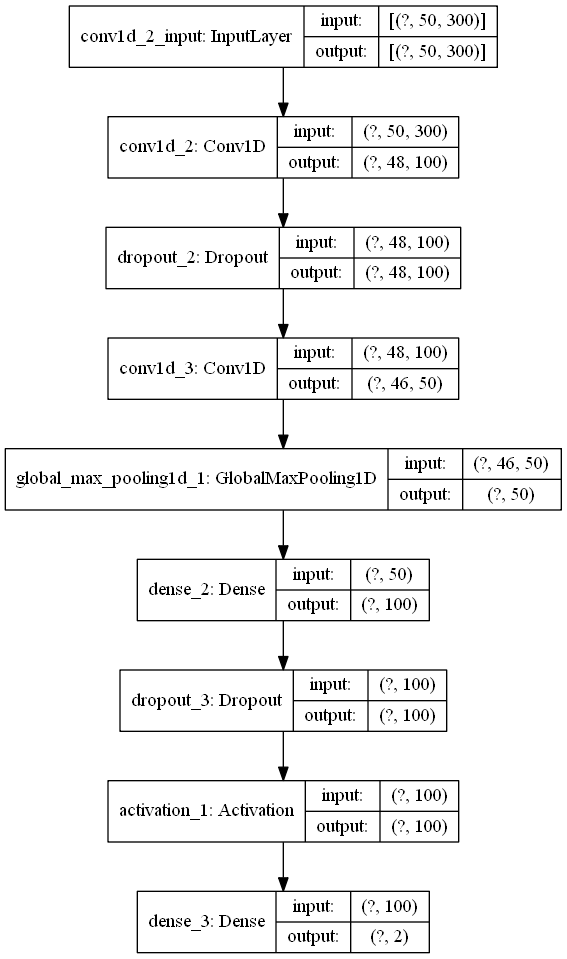

In [44]:
model = Sequential()

# Filtros, la cantidad de copias que se realizan en los documentos
model.add(Conv1D(100, kernel_size, padding='valid', activation='relu', strides=1, 
                 input_shape=(maxlen, embedding_dims)))
model.add(Dropout(dropout))

model.add(Conv1D(50, kernel_size, padding='valid', activation='relu', strides=1))
#Reducimos la dimension a 1 dimension, para poder aplicar una capa densa
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(dropout))
model.add(Activation('relu'))

model.add(Dense(num_labels, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [46]:
# numero de kernel o ventana igual a 3
# numero de dimension de cada token igual a 300
# bias igual a 1
# numero de copias de cada documento igual a 100
((3*300) + 1)*100

90100

In [47]:
((3*100) + 1)*50

15050

### Entrenamos

In [48]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/2
176/176 [==============================] - 2s 11ms/step - loss: 0.7280 - accuracy: 0.5214 - val_loss: 0.6924 - val_accuracy: 0.5230
Epoch 2/2
76/76 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5230

Test accuracy: 52.3%
